In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
import time

%load_ext autoreload
%autoreload 2
from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

# Import Combined Data

In [18]:
df_all = pd.DataFrame.from_csv('../data_ski_in_solitude/all_data_with_feat.csv')

In [19]:
if type(df_all.day_of_week[0]) != int:
    df_all = day_of_week_col(df_all)

AttributeError: 'DataFrame' object has no attribute 'day_of_week'

In [20]:
df_all.head()

,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,...,new_years_sat,mlk_sat,new_years_sun,mlk_sun,new_years_fri,mlk_fri,new_years_mon,mlk_mon,spring_break,spring_break_ends
2011-11-10,573.576923,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,7.130573,2.012346,3.037267,...,0,0,0,0,0,0,0,0,0,0
2011-11-11,573.576923,1.009146,41.515244,75.786585,13.911585,43.262195,83.945122,7.130573,2.012346,3.037267,...,0,0,0,0,0,0,0,0,0,0
2011-11-12,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,7.130573,2.012346,3.037267,...,0,0,0,0,0,0,0,0,0,0
2011-11-13,44.000000,1.000000,18.000000,0.000000,0.000000,0.000000,1.000000,7.130573,0.000000,3.037267,...,0,0,0,0,0,0,0,0,0,0
2011-11-14,-1467.000000,3.000000,18.000000,0.000000,0.000000,0.000000,4.000000,7.130573,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0


ValueError: x must have at least one data point

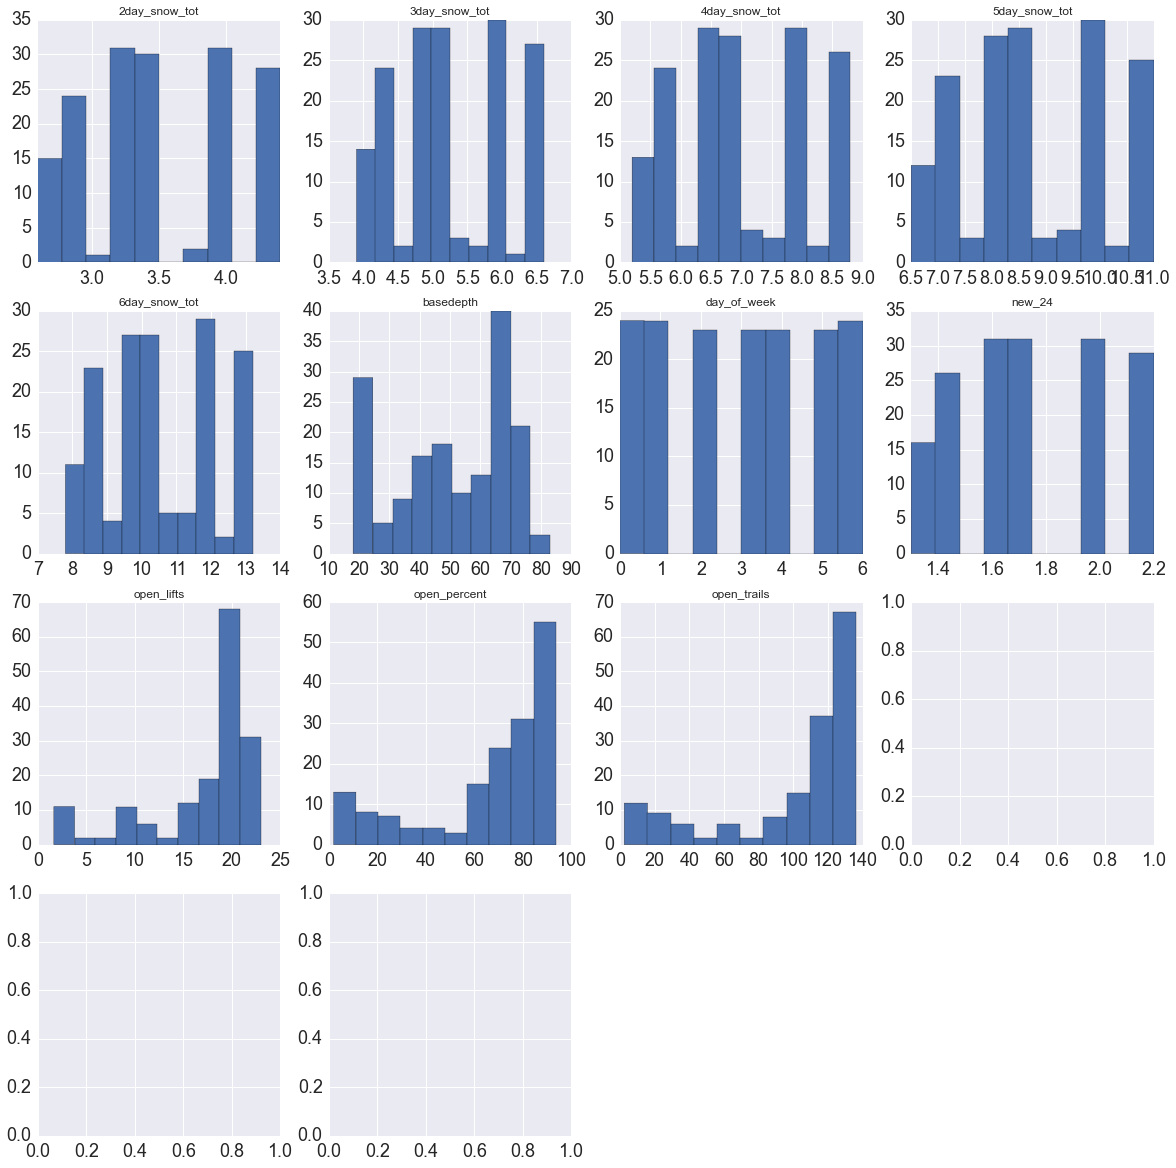

In [1294]:
df_all.hist(figsize=(20,20), xlabelsize = 10, ylabelsize = 10)

#### Create a crowd yesterday column

In [1323]:
#df_all['crowd_yest'] = df_all.skiers.shift(1)

#### Create dummy variables for days of the week.

In [1324]:
df_all = pd.concat([df_all, pd.get_dummies(df_all.day_of_week, prefix='day')], axis=1)

In [1325]:
df_all.head()

,day_of_week,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,2day_snow_tot,...,4day_snow_tot,5day_snow_tot,6day_snow_tot,day_0,day_1,day_2,day_3,day_4,day_5,day_6
2015-11-15,6,NaN,1.3,18.0,2.50,2.25,2.25,1.3,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,1
2015-11-16,0,NaN,1.3,18.0,3.00,2.50,2.50,2.6,NaN,NaN,...,NaN,NaN,NaN,1,0,0,0,0,0,0
2015-11-17,1,NaN,1.3,19.5,3.25,2.50,2.75,3.9,NaN,2.6,...,NaN,NaN,NaN,0,1,0,0,0,0,0
2015-11-18,2,NaN,1.3,18.0,3.75,2.50,2.00,5.2,NaN,2.6,...,NaN,NaN,NaN,0,0,1,0,0,0,0
2015-11-19,3,NaN,1.3,18.0,6.60,2.60,2.80,6.5,NaN,2.6,...,5.2,NaN,NaN,0,0,0,1,0,0,0


### Drop day of week column

In [1326]:
df_all = df_all.drop(['day_of_week'], axis=1)

#### Make month column

In [1327]:
df_all['month'] = df_all.index.month

In [1328]:
df_all = pd.concat([df_all, pd.get_dummies(df_all.month, prefix='month')], axis=1)

In [1329]:
df_all.drop(['month'], axis=1, inplace=True)

#### Make holiday features

In [1330]:
L = len(df_all)-1
holidays = get_holiday_list(df_all.index[0].year, df_all.index[0].month, df_all.index[0].day, df_all.index[L].year, df_all.index[L].month, df_all.index[L].day)

In [1331]:
vet_day, thanksgiv, xmas, new_years, mlk_day, pres_day = get_holiday_names(holidays)

In [1332]:
df_try = call_make_holiday_columns(df_all, vet_day, thanksgiv, xmas, new_years, mlk_day, pres_day)

In [1333]:
pd.options.display.max_rows = 999

#### Create (holiday)(weekend) and (holiday)(fri/mon/weekday) features

In [1334]:
df_all['new_years_sat'] = df_all.filter(regex="day_5")*df_all.new_years
df_all['mlk_sat'] = df_all.filter(regex="day_5")*df_all.mlk_day

In [1335]:
df_all['new_years_sun'] = df_all.filter(regex="day_6")*df_all.new_years
df_all['mlk_sun'] = df_all.filter(regex="day_6")*df_all.mlk_day

In [1336]:
df_all['new_years_fri'] = df_all.filter(regex="day_4")*df_all.new_years
df_all['mlk_fri'] = df_all.filter(regex="day_4")*df_all.mlk_day

In [1337]:
df_all['new_years_mon'] = df_all.filter(regex="day_0")*df_all.new_years
df_all['mlk_mon'] = df_all.filter(regex="day_0")*df_all.mlk_day

### Make spring break column

In [1338]:
df_all = make_spring_break_col(df_all, holiday, 'hol_name')

In [1339]:
df_all = make_spring_trailing_weeks(df_all, holiday, 'hol_name')

In [1340]:
df_all.fillna(df_all.mean(), inplace=True)

,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,...,new_years_sat,mlk_sat,new_years_sun,mlk_sun,new_years_fri,mlk_fri,new_years_mon,mlk_mon,spring_break,spring_break_ends
2015-11-15,NaN,1.3,18.000000,2.500000,2.250000,2.250000,1.3,12.296815,3.488272,5.239752,...,0,0,0,0,0,0,0,0,0,0
2015-11-16,NaN,1.3,18.000000,3.000000,2.500000,2.500000,2.6,12.296815,3.488272,5.239752,...,0,0,0,0,0,0,0,0,0,0
2015-11-17,NaN,1.3,19.500000,3.250000,2.500000,2.750000,3.9,12.296815,2.600000,5.239752,...,0,0,0,0,0,0,0,0,0,0
2015-11-18,NaN,1.3,18.000000,3.750000,2.500000,2.000000,5.2,12.296815,2.600000,3.900000,...,0,0,0,0,0,0,0,0,0,0
2015-11-19,NaN,1.3,18.000000,6.600000,2.600000,2.800000,6.5,12.296815,2.600000,3.900000,...,0,0,0,0,0,0,0,0,0,0
2015-11-20,NaN,1.3,18.000000,4.333333,1.666667,3.333333,7.8,12.296815,2.600000,3.900000,...,0,0,0,0,0,0,0,0,0,0
2015-11-21,NaN,1.3,18.000000,7.000000,2.333333,5.000000,9.1,12.296815,2.600000,3.900000,...,0,0,0,0,0,0,0,0,0,0
2015-11-22,NaN,1.3,18.000000,5.800000,3.000000,4.400000,10.4,9.100000,2.600000,3.900000,...,0,0,0,0,0,0,0,0,0,0
2015-11-23,NaN,1.3,18.500000,8.500000,3.000000,3.750000,11.7,9.100000,2.600000,3.900000,...,0,0,0,0,0,0,0,0,0,0
2015-11-24,NaN,1.3,19.000000,7.250000,3.750000,4.000000,13.0,9.100000,2.600000,3.900000,...,0,0,0,0,0,0,0,0,0,0


### Export data with features

In [60]:
df_all = pd.DataFrame.from_csv('../data_ski_in_solitude/all_data_with_feat.csv')

In [54]:
df_all.fillna(df_all.mean(), inplace=True)

,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,...,new_years_sat,mlk_sat,new_years_sun,mlk_sun,new_years_fri,mlk_fri,new_years_mon,mlk_mon,spring_break,spring_break_ends
2011-11-10,573.576923,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,7.130573,2.012346,3.037267,...,0,0,0,0,0,0,0,0,0,0
2011-11-11,573.576923,1.009146,41.515244,75.786585,13.911585,43.262195,83.945122,7.130573,2.012346,3.037267,...,0,0,0,0,0,0,0,0,0,0
2011-11-12,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,7.130573,2.012346,3.037267,...,0,0,0,0,0,0,0,0,0,0
2011-11-13,44.000000,1.000000,18.000000,0.000000,0.000000,0.000000,1.000000,7.130573,0.000000,3.037267,...,0,0,0,0,0,0,0,0,0,0
2011-11-14,-1467.000000,3.000000,18.000000,0.000000,0.000000,0.000000,4.000000,7.130573,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0
2011-11-15,-1580.000000,0.000000,18.000000,0.000000,0.000000,0.000000,4.000000,7.130573,4.000000,4.000000,...,0,0,0,0,0,0,0,0,0,0
2011-11-16,-1315.000000,1.000000,18.000000,0.000000,0.000000,0.000000,5.000000,7.130573,3.000000,4.000000,...,0,0,0,0,0,0,0,0,0,0
2011-11-17,-1202.000000,1.000000,18.000000,0.000000,0.000000,0.000000,6.000000,7.130573,1.000000,4.000000,...,0,0,0,0,0,0,0,0,0,0
2011-11-18,-1176.000000,0.000000,18.000000,0.000000,0.000000,0.000000,6.000000,6.000000,2.000000,2.000000,...,0,0,0,0,0,0,0,0,0,0
2011-11-19,23.000000,1.000000,18.000000,0.000000,0.000000,0.000000,7.000000,6.000000,1.000000,2.000000,...,0,0,0,0,0,0,0,0,0,0


In [55]:
features = list(df_all.columns[1:].values)

In [57]:
df_sc, standard_scale_fit = scale_features(df_all[features])

In [58]:
df_final = pd.concat([df_all.skiers, df_sc], axis=1)

In [59]:
df_final.head()

,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,...,new_years_sat,mlk_sat,new_years_sun,mlk_sun,new_years_fri,mlk_fri,new_years_mon,mlk_mon,spring_break,spring_break_ends
2011-11-10,573.576923,-0.728536,-1.757117,-2.267958,-2.775779,-2.060768,-1.483913,-0.5111,-0.337106,-0.380895,...,-0.049538,-0.035007,-0.049538,-0.035007,-0.049538,-0.035007,-0.035007,-0.035007,-0.170198,-0.092962
2011-11-11,573.576923,-0.267665,-0.431049,-0.562669,-0.518840,-0.710048,-0.553476,-0.5111,-0.337106,-0.380895,...,-0.049538,-0.035007,-0.049538,-0.035007,-0.049538,-0.035007,-0.035007,-0.035007,-0.170198,-0.092962
2011-11-12,0.000000,-0.728536,-1.607082,-2.267958,-2.775779,-2.060768,-1.483913,-0.5111,-0.337106,-0.380895,...,-0.049538,-0.035007,-0.049538,-0.035007,-0.049538,-0.035007,-0.035007,-0.035007,-0.170198,-0.092962
2011-11-13,44.000000,-0.271842,-1.607082,-2.267958,-2.775779,-2.060768,-1.472829,-0.5111,-0.916571,-0.380895,...,-0.049538,-0.035007,-0.049538,-0.035007,-0.049538,-0.035007,-0.035007,-0.035007,-0.170198,-0.092962
2011-11-14,-1467.000000,0.641546,-1.607082,-2.267958,-2.775779,-2.060768,-1.439577,-0.5111,-0.628616,-0.827921,...,-0.049538,-0.035007,-0.049538,-0.035007,-0.049538,-0.035007,-0.035007,-0.035007,-0.170198,-0.092962


In [61]:
df_final.to_csv('../data_ski_in_solitude/all_feat_scaled.csv')